In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 200)
from datasets import get_pyspark_titanic, get_sklearn_titanic
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from deepchecks.suites import full_suite
from deepchecks import Dataset

seed=0

/home/haftamu/.local/lib/python3.8/site-packages/deepchecks/suites.py:21: DeprecationWarning:

Ability to import tabular suites from the `deepchecks.suites` is deprecated, please import from `deepchecks.tabular.suites` instead

/home/haftamu/.local/lib/python3.8/site-packages/deepchecks/__init__.py:136: DeprecationWarning:

Ability to import base tabular functionality from the `deepchecks` package directly is deprecated, please import from `deepchecks.tabular` instead



In [5]:
models = ["LinearSVC", "Logistic Regression", "Decision Tree", "Random Forest", "Naive Bayes", "Gradient Boosting", "MLP Classifier", "One vs Rest", "Keras Network"]

In [6]:
x_train, x_test, y_train, y_test = get_sklearn_titanic()

**ValueError: Cannot run multiple SparkContexts at once**
* Add sc.stop() before invoking the method as shown below

In [8]:
sc.stop()
train, test = get_pyspark_titanic()

22/10/27 11:43:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/27 11:43:26 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/27 11:43:26 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/10/27 11:43:26 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/10/27 11:43:26 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


Load all Scikit-Learn classifiers and build the models

In [9]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay



sklearn_classifiers = [
    LinearSVC(random_state=seed),
    LogisticRegression(random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    RandomForestClassifier(random_state=seed),
    GaussianNB(),
    GradientBoostingClassifier(random_state=seed),
    MLPClassifier(random_state=seed),
    OneVsRestClassifier(LinearSVC())
]

sklearn_accuracy = []
sklearn_confusion = []
sklearn_roc = []
sklearn_precision = []
sklearn_recall = []
for clf in sklearn_classifiers:
    clf.fit(x_train, y_train)
    sklearn_accuracy.append(clf.score(x_test, y_test))
    sklearn_confusion.append(confusion_matrix(clf.predict(x_test), y_test))
    sklearn_roc.append(roc_auc_score(y_test, clf.predict(x_test)))
    sklearn_precision.append(precision_score(y_test, clf.predict(x_test)))
    sklearn_recall.append(recall_score(y_test, clf.predict(x_test)))

Load all PySpark classifiers and build the models

In [10]:

from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import OneVsRest


pyspark_classifiers = [
    LinearSVC(labelCol="label"),
    LogisticRegression(labelCol="label"),
    DecisionTreeClassifier(labelCol="label", seed=seed),
    RandomForestClassifier(labelCol = 'label', seed=seed),
    NaiveBayes(labelCol = 'label', modelType="gaussian"),
    GBTClassifier(labelCol = 'label', seed=seed),
    MultilayerPerceptronClassifier(labelCol = 'label', seed=seed, layers=[len(test.toPandas()["features"][0]),100,]),
    OneVsRest(labelCol = 'label', classifier=LinearSVC())
]

pyspark_accuracy = []
pyspark_confusion = []
pyspark_roc = []
pyspark_precision = []
pyspark_recall = []
for clf in pyspark_classifiers:
    clf = clf.fit(train)
    evaluator=MulticlassClassificationEvaluator(metricName="accuracy")
    pyspark_accuracy.append(evaluator.evaluate(clf.transform(test)))
    pyspark_confusion.append(confusion_matrix(clf.transform(test).select("prediction").collect(), \
                      clf.transform(test).select("label").collect()))
    pyspark_roc.append(roc_auc_score(clf.transform(test).select("label").collect(), \
                      clf.transform(test).select("prediction").collect()))
    pyspark_precision.append(precision_score(clf.transform(test).select("label").collect(), \
                      clf.transform(test).select("prediction").collect()))
    pyspark_recall.append(recall_score(clf.transform(test).select("label").collect(), \
                      clf.transform(test).select("prediction").collect()))

22/10/27 11:45:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/27 11:45:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/10/27 11:46:12 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/27 11:46:12 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


**Warning to check later**
* WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
* WARN Failed to load implementationfrom:dev.ludovic.netlib.blas.ForeignLinkerBLAS
* WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
* WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS

Load Keras classifier and build the model

In [13]:
import tensorflow.keras as keras

clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train)
sklearn_accuracy.append(clf.evaluate(x_test, y_test)[1])
sklearn_confusion.append(confusion_matrix(np.round(clf.predict(x_test)), y_test))
sklearn_roc.append(roc_auc_score(y_test, np.round(clf.predict(x_test))))
sklearn_precision.append(precision_score(y_test, np.round(clf.predict(x_test))))
sklearn_recall.append(recall_score(y_test, np.round(clf.predict(x_test))))
pyspark_accuracy.append(clf.evaluate(x_test, y_test)[1])
pyspark_confusion.append(confusion_matrix(np.round(clf.predict(x_test)), y_test))
pyspark_roc.append(roc_auc_score(y_test, np.round(clf.predict(x_test))))
pyspark_precision.append(precision_score(y_test, np.round(clf.predict(x_test))))
pyspark_recall.append(recall_score(y_test, np.round(clf.predict(x_test))))

2022-10-27 11:50:25.368043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 11:50:25.368068: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-27 11:50:28.389498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-27 11:50:28.389577: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-27 11:50:28.389662: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Haftamu-YOGA): /proc/driver/nvidia/version does not exist
2022-10-27 11:50:28.390669: I tensorflow/core/platform/cpu_featu

4/4 [==============================] - 0s 2ms/step


Plot Scikit-Learn and PySpark Accuracy score

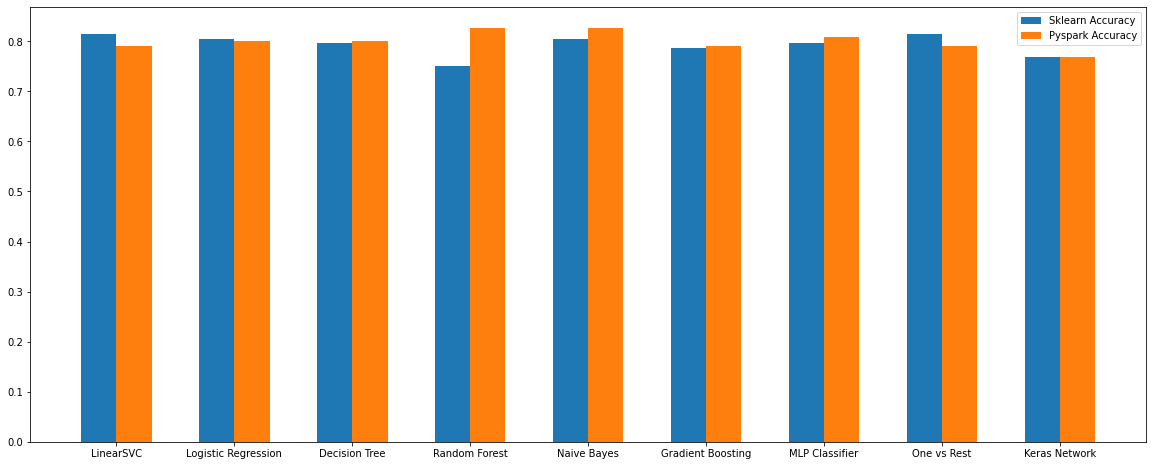

In [14]:
plt.figure(figsize=(20,8))
plt.bar(models, sklearn_accuracy, align="edge", width=-0.3)
plt.bar(models, pyspark_accuracy, align="edge", width=0.3)
plt.legend(["Sklearn Accuracy", "Pyspark Accuracy"])

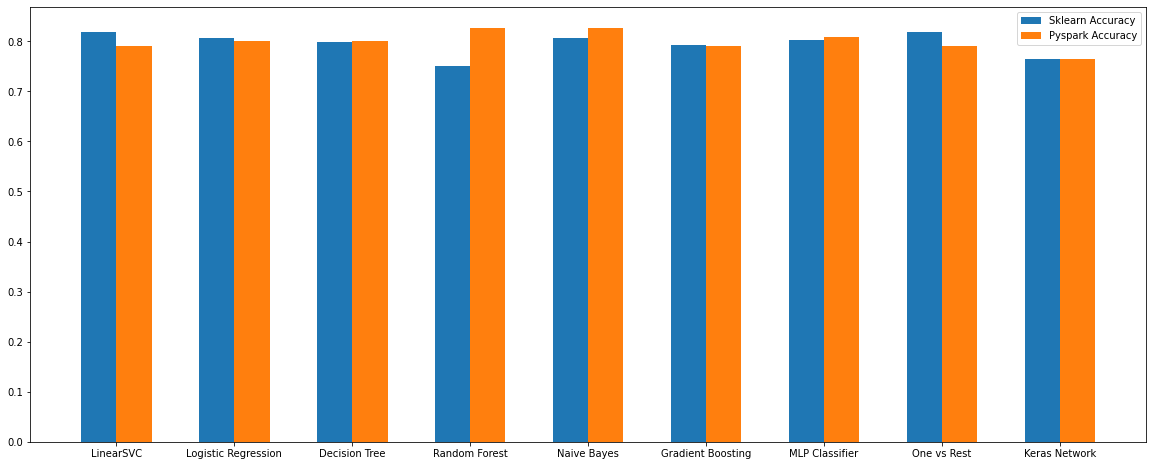

In [15]:
plt.figure(figsize=(20,8))
plt.bar(models, sklearn_roc, align="edge", width=-0.3)
plt.bar(models, pyspark_roc, align="edge", width=0.3)
plt.legend(["Sklearn Accuracy", "Pyspark Accuracy"])

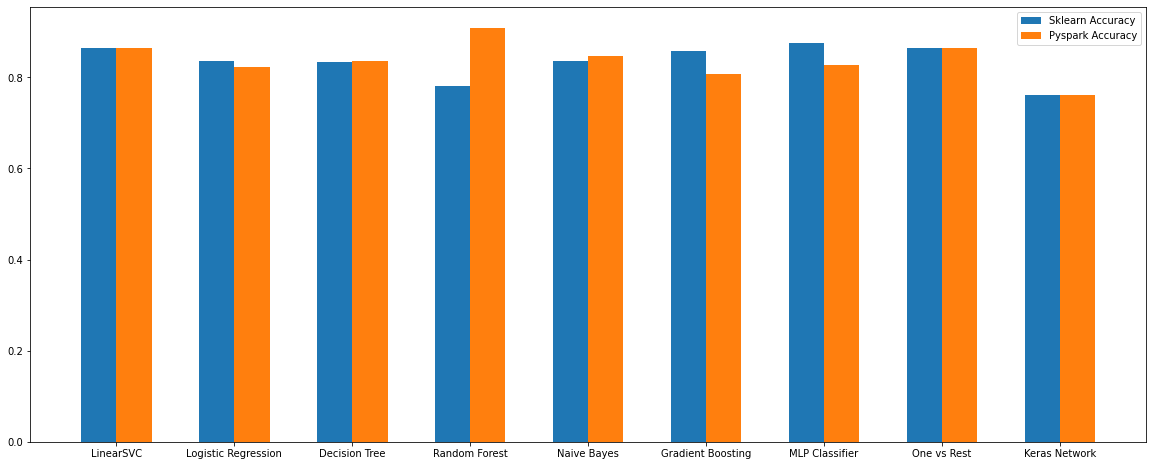

In [16]:
plt.figure(figsize=(20,8))
plt.bar(models, sklearn_precision, align="edge", width=-0.3)
plt.bar(models, pyspark_precision, align="edge", width=0.3)
plt.legend(["Sklearn Accuracy", "Pyspark Accuracy"])

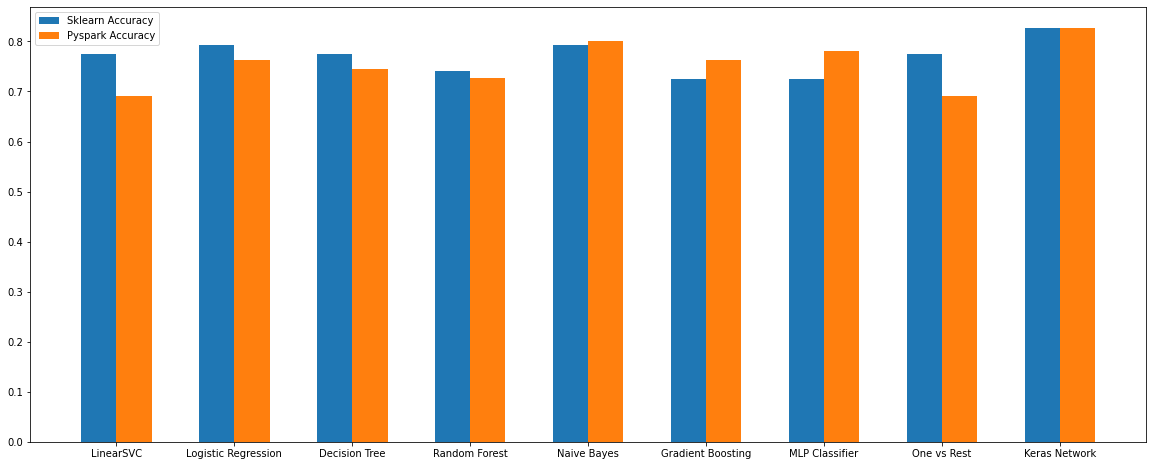

In [17]:
plt.figure(figsize=(20,8))
plt.bar(models, sklearn_recall, align="edge", width=-0.3)
plt.bar(models, pyspark_recall, align="edge", width=0.3)
plt.legend(["Sklearn Accuracy", "Pyspark Accuracy"])

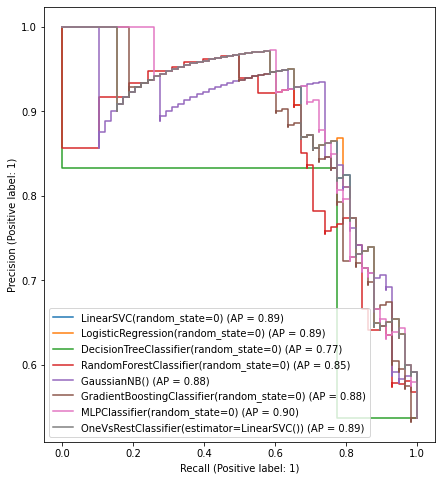

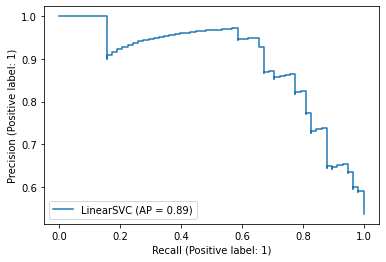

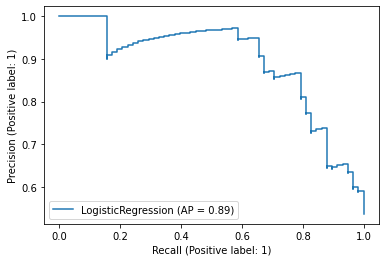

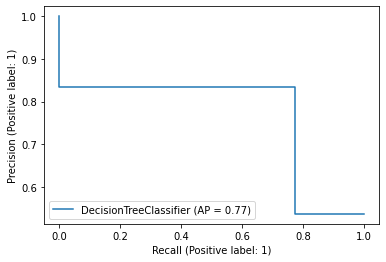

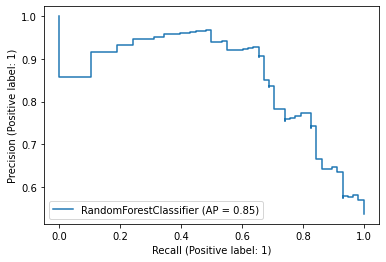

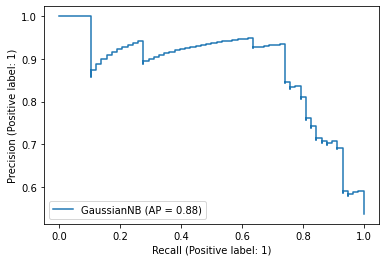

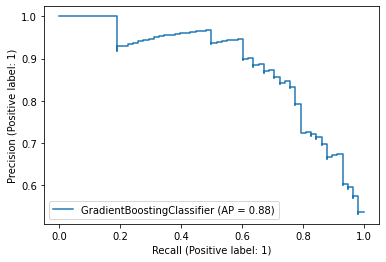

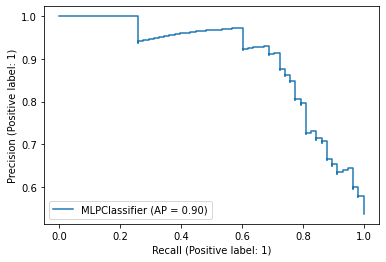

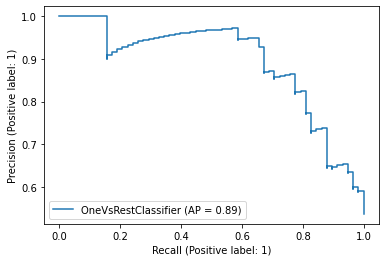

In [18]:
_, ax = plt.subplots(figsize=(7, 8))
for clf in sklearn_classifiers:
    PrecisionRecallDisplay.from_estimator(clf, x_test, y_test).plot(ax=ax, name=clf)

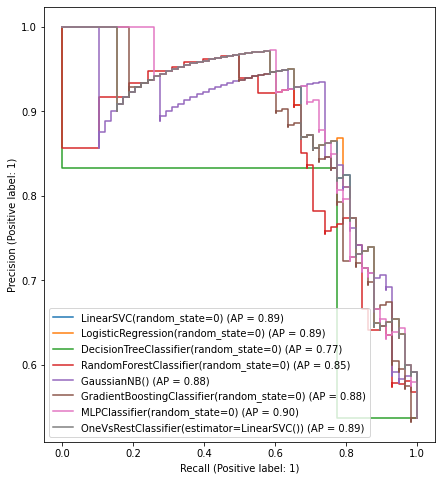

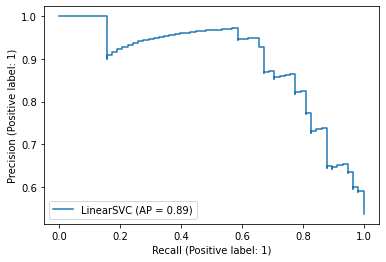

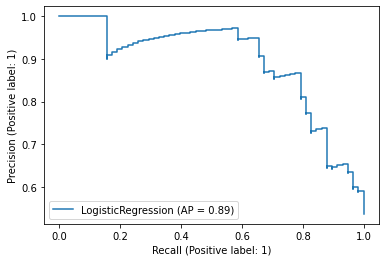

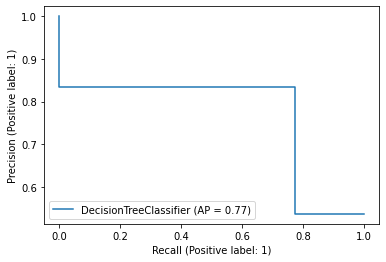

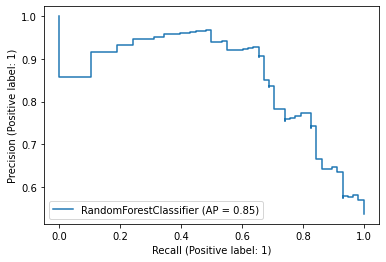

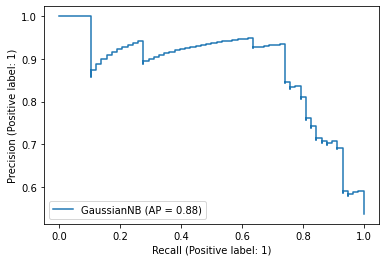

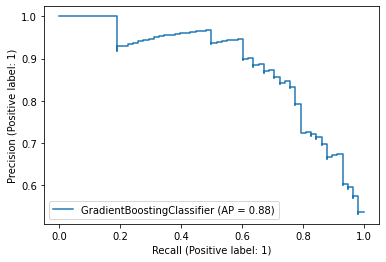

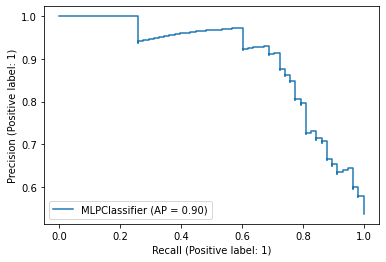

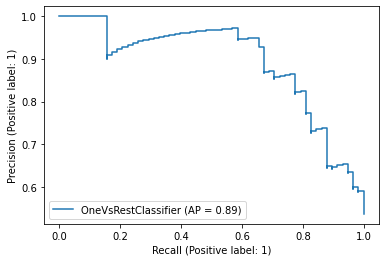

In [19]:
_, ax = plt.subplots(figsize=(7, 8))
for clf in sklearn_classifiers:
    PrecisionRecallDisplay.from_estimator(clf, x_test, y_test).plot(ax=ax, name=clf)

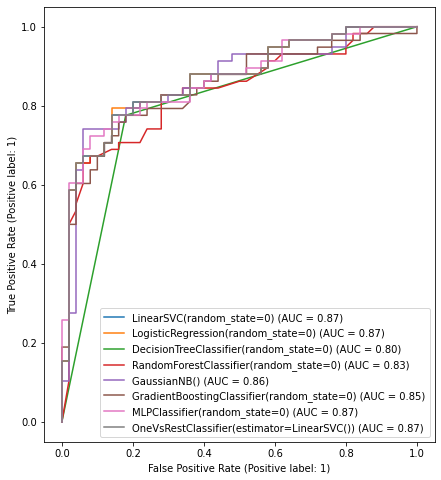

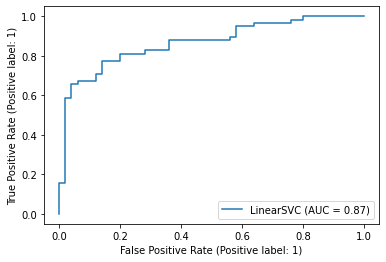

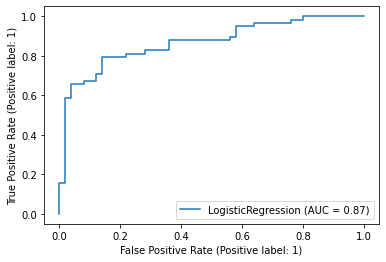

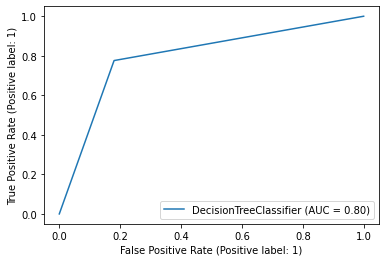

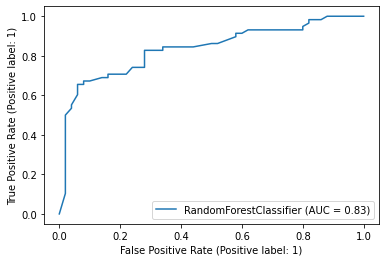

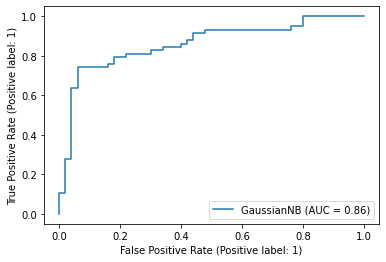

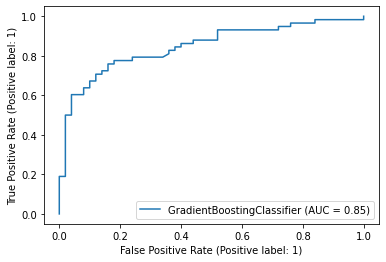

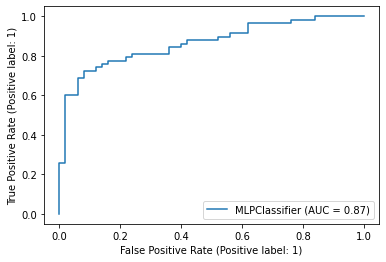

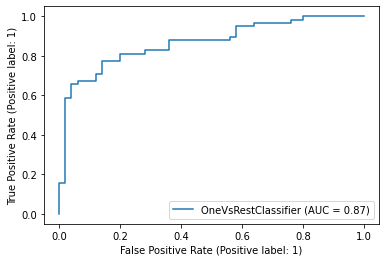

In [20]:
_, ax = plt.subplots(figsize=(7, 8))
for clf in sklearn_classifiers:
    RocCurveDisplay.from_estimator(clf, x_test, y_test).plot(ax=ax, name=clf)

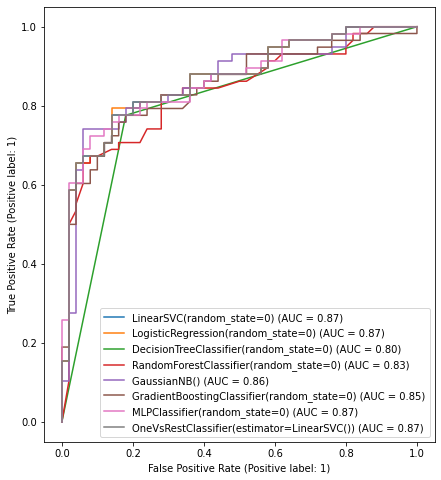

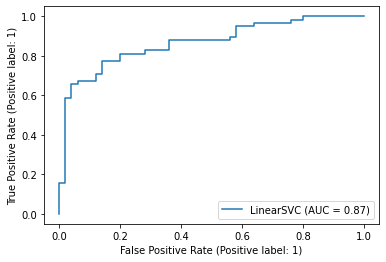

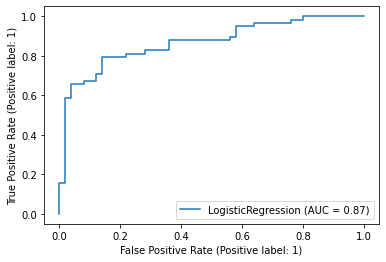

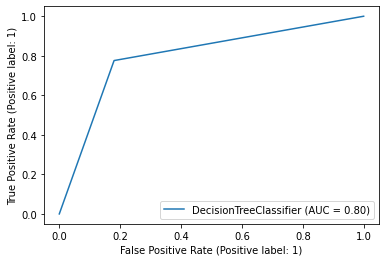

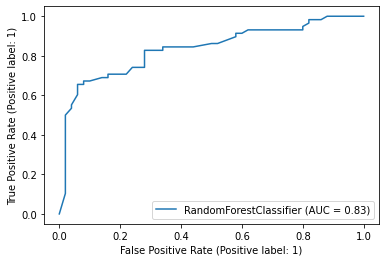

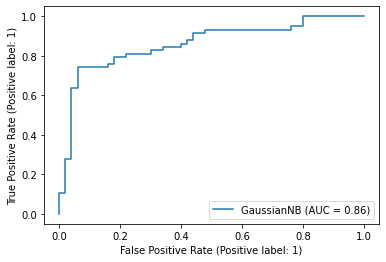

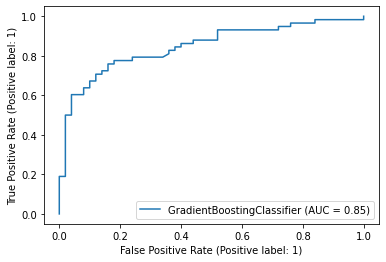

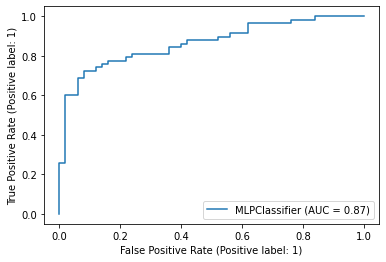

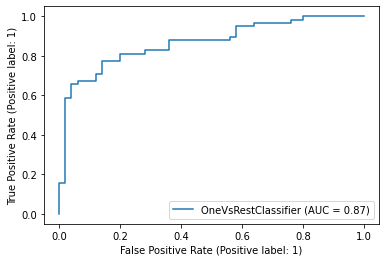

In [21]:
_, ax = plt.subplots(figsize=(7, 8))
for clf in sklearn_classifiers:
    RocCurveDisplay.from_estimator(clf, x_test, y_test).plot(ax=ax, name=clf)
    

In [26]:
import os
print(os.environ['PATH'])

/home/haftamu/anaconda3/condabin:/home/haftamu/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/opt/spark/bin:/opt/spark/sbin


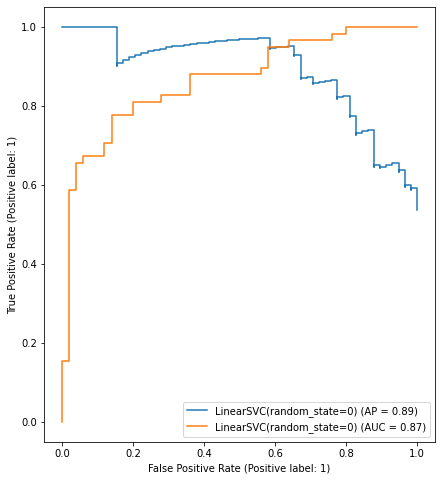

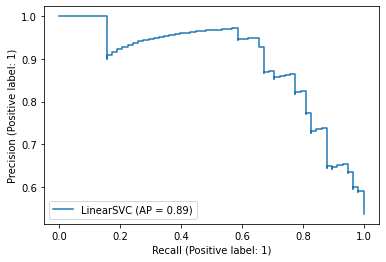

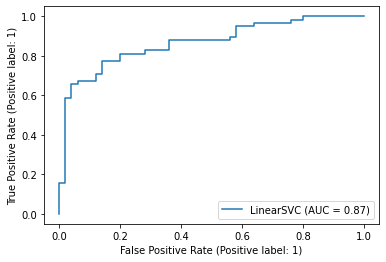

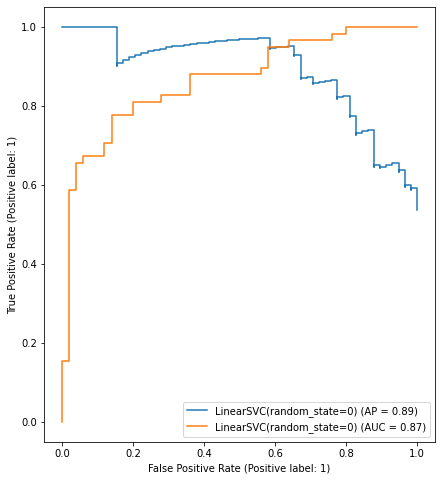

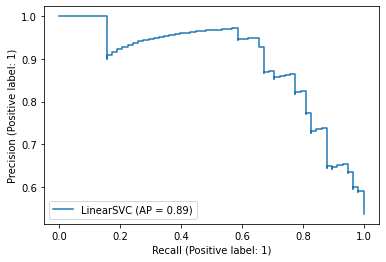

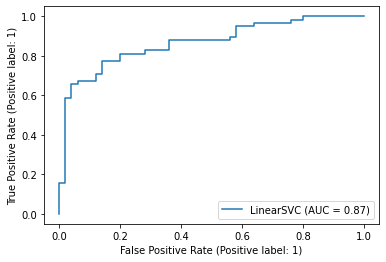

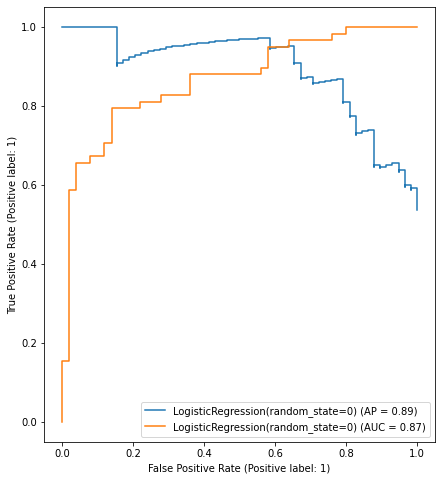

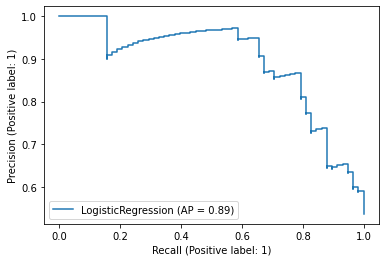

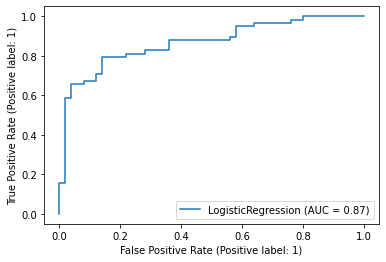

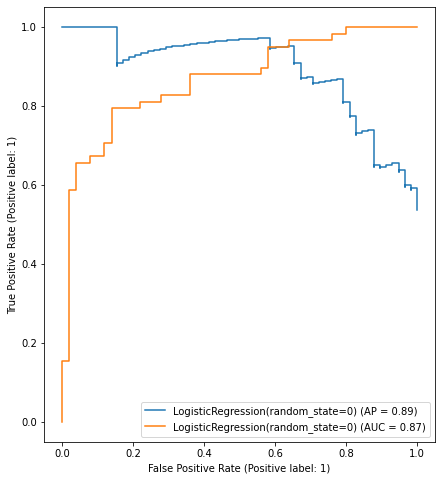

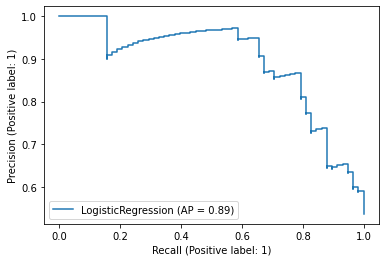

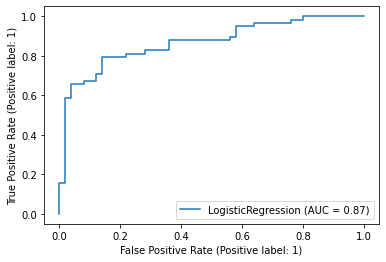

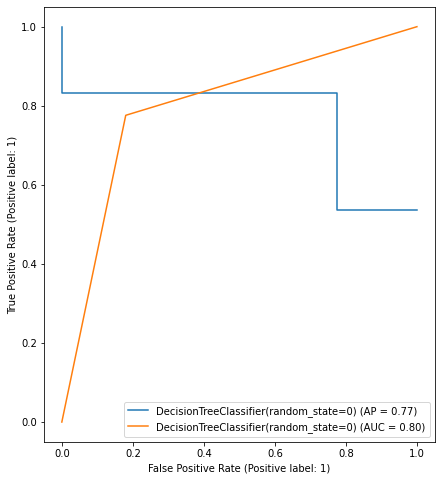

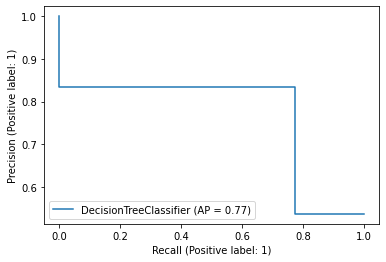

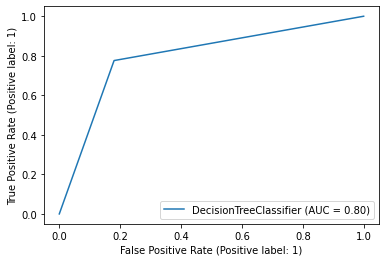

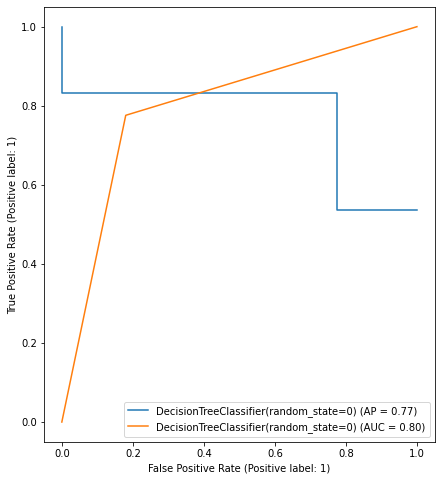

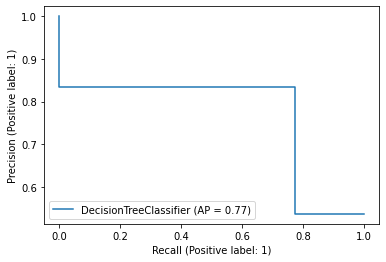

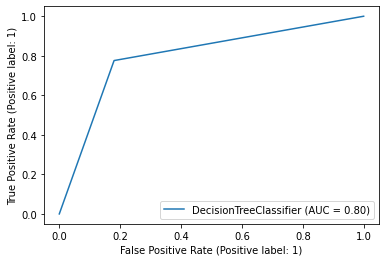

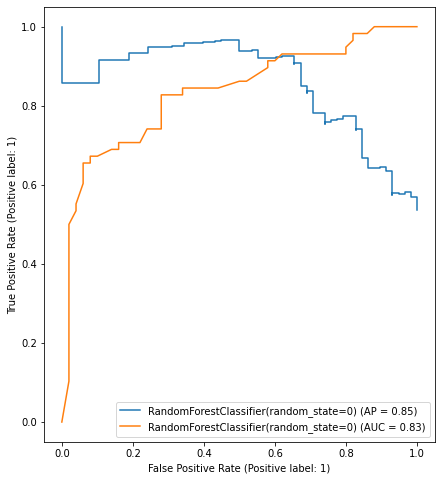

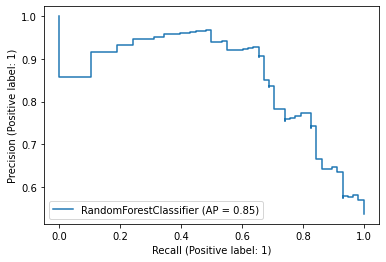

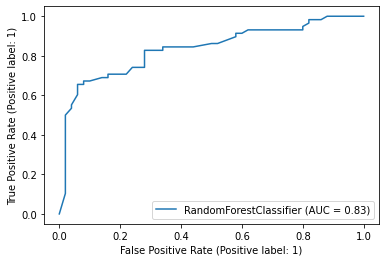

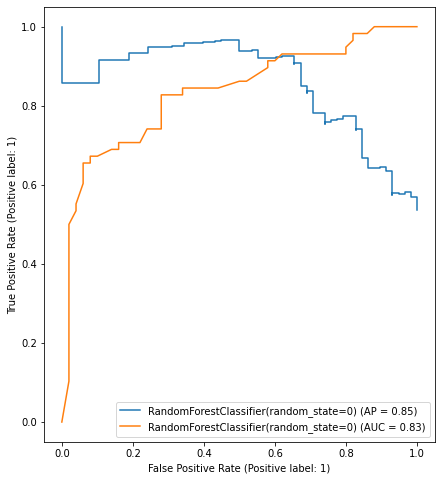

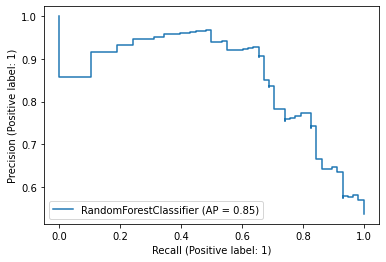

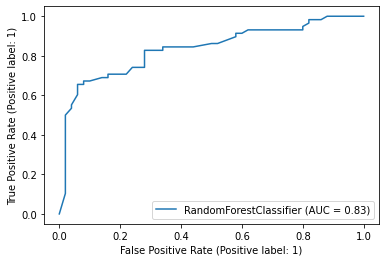

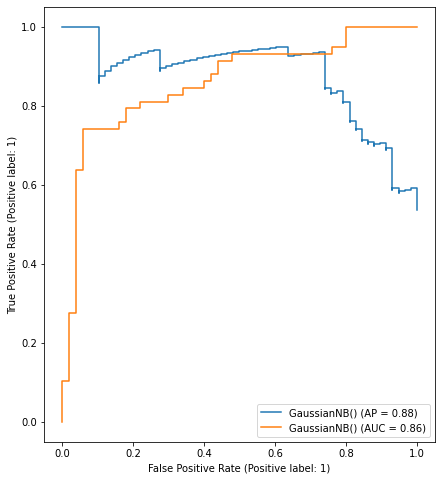

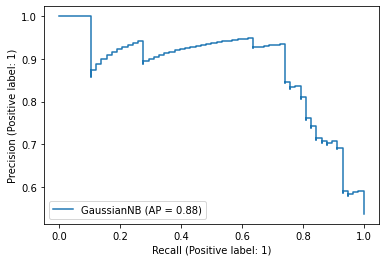

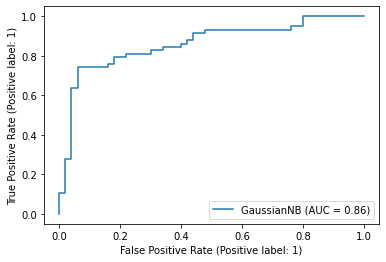

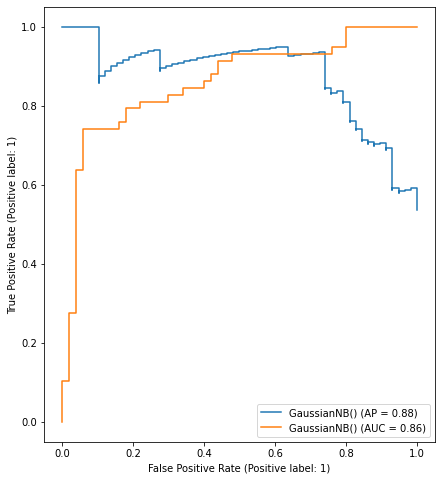

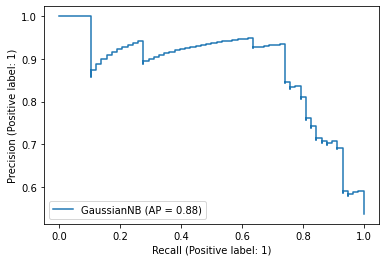

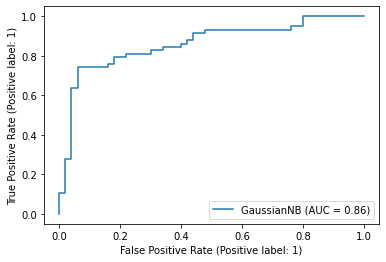

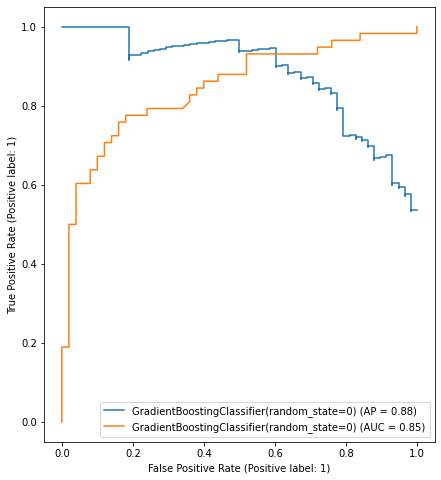

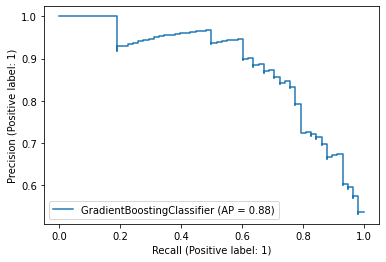

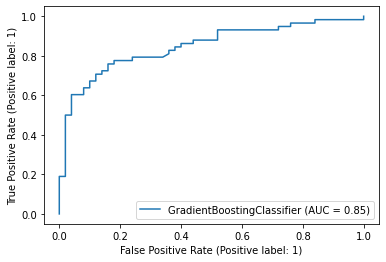

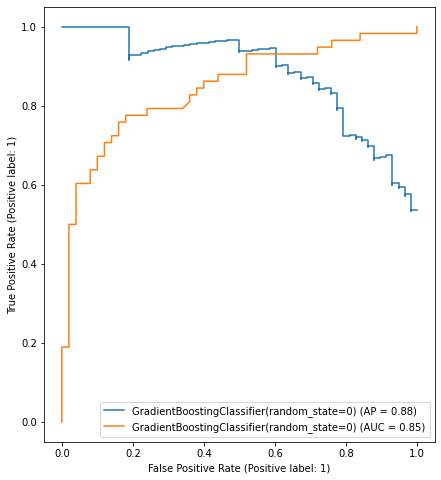

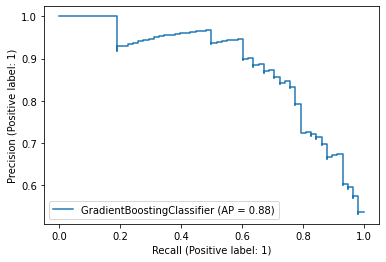

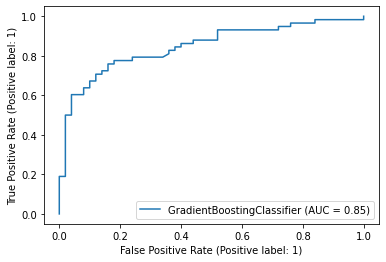

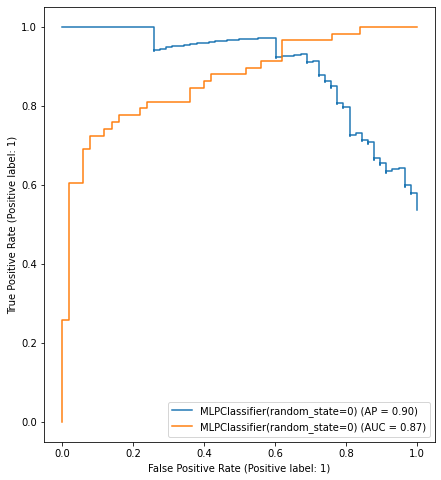

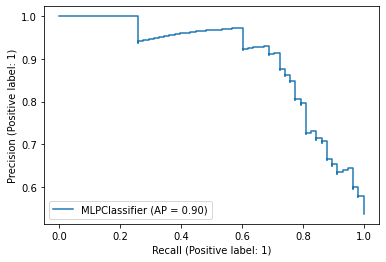

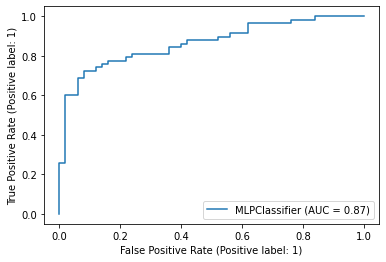

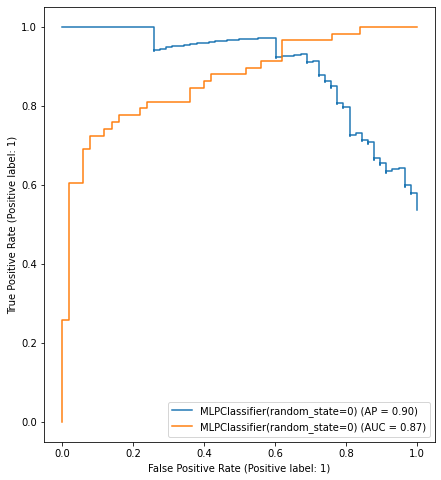

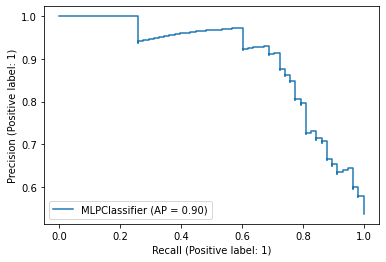

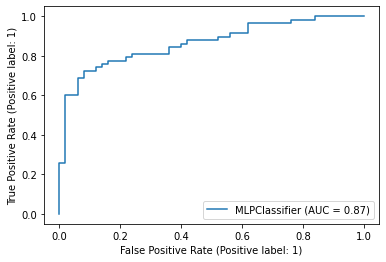

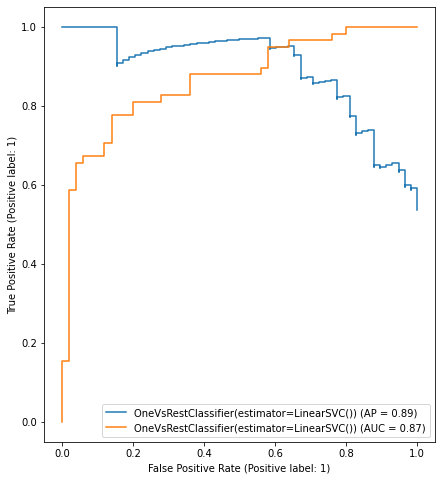

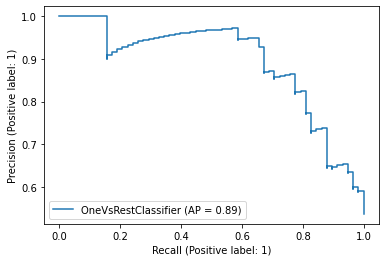

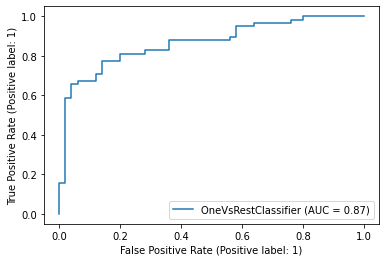

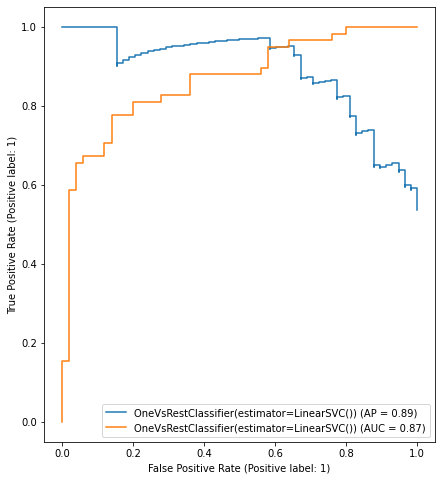

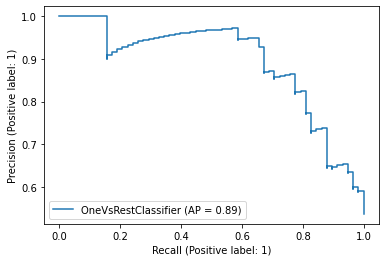

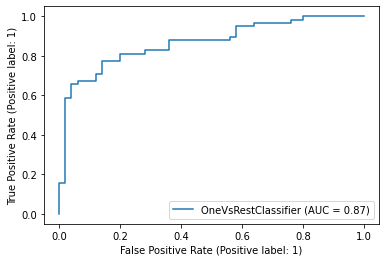

In [22]:
for clf in sklearn_classifiers:
    _, ax = plt.subplots(figsize=(7, 8))
    PrecisionRecallDisplay.from_estimator(clf, x_test, y_test).plot(ax=ax, name=clf)
    RocCurveDisplay.from_estimator(clf, x_test, y_test).plot(ax=ax, name=clf)
    _, bx = plt.subplots(figsize=(7, 8))
    PrecisionRecallDisplay.from_estimator(clf, x_test, y_test).plot(ax=bx, name=clf)
    RocCurveDisplay.from_estimator(clf, x_test, y_test).plot(ax=bx, name=clf)